# specMACS cloudmask

The following script exemplifies the access and usage of specMACS data measured 
during EUREC4A.

The specMACS sensor consists of hyperspectral image sensors as well as polarization resolving image sensors.
The hyperspectral image sensors operate in the visible and near infrared (VNIR) and the short-wave infrared (SWIR) range.
The dataset investigated in this notebook is a cloud mask dataset based on data from the SWIR sensor.
More information on the dataset can be found on the [macsServer](https://macsserver.physik.uni-muenchen.de/campaigns/EUREC4A/products/cloudmask/). If you have questions or if you would like to use the data for a publication, please don't hesitate to get in contact with the dataset authors as stated in the dataset attributes `contact` and `author` list.

Our plan is to analyze a section of the specMACS cloud mask dataset around the first `GOOD` dropsonde on the second HALO circle on the 5th of February (`HALO-0205_c2`). We'll first look at the cloudiness just along the flight track and later on create a map projection of the dataset. This notebook will guide you through the required steps.

## Obtaining data
In order to work with EUREC4A datasets, we'll use the `eurec4a` library to access the datasets and also use `numpy` and `xarray` as our common tools to handle datasets.

In [1]:
import eurec4a
import numpy as np
import xarray as xr

### Finding the right sonde
All HALO flights were split up into flight phases or segments to allow for a precise selection in time and space of a circle or calibration pattern. For more information have a look at the respective [github repository](https://github.com/eurec4a/halo-flight-phase-separation).

In [2]:
all_flight_segments = eurec4a.get_flight_segments()

The flight segmentation data is organized by platform and flight, but as we want to look up a segment by its `segment_id`, we'll have to flatten the data and reorganize it by the `segment_id`. Additionally, we want to be able to extract the `flight_id` and `platform_id` back from a selected segment, so we add this information to each individual segment:

In [3]:
segments_by_segment_id = {
    s["segment_id"]: {
        **s,
        "platform_id": platform_id,
        "flight_id": flight_id
    }
    for platform_id, flights in all_flight_segments.items()
    for flight_id, flight in flights.items()
    for s in flight["segments"]
}

We want to extract the id of the first dropsonde of the second HALO circle on February 5 (`HALO-0205_c2`). By the way: In the {doc}`velox` example the measurement of this time is shown as well.

In [4]:
segment = segments_by_segment_id["HALO-0205_c2"]
first_dropsonde = segment["dropsondes"]["GOOD"][0]
first_dropsonde

'HALO-0205_s13'

Now we would like to know when this sonde was launched. The [JOANNE dataset](https://github.com/Geet-George/JOANNE#joanne---the-eurec4a-dropsonde-dataset) contains this information. We use level 3 data which contains quality checked data on a common grid and load it using the intake catalog. We then select the correct dropsonde by its `sonde_id` to find out the launch time of the dropsonde.

More information on the data catalog can be found [here](https://github.com/eurec4a/eurec4a-intake#eurec4a-intake-catalogue).

In [5]:
cat = eurec4a.get_intake_catalog()

In [6]:
dropsondes = cat.dropsondes.JOANNE.level3.to_dask()
# this following line should go away in the soon to be released new version of JOANNE
sonde_dt = dropsondes.swap_dims({"sounding": "sonde_id"}).sel(sonde_id=first_dropsonde).launch_time.values
str(sonde_dt)

'2020-02-05T10:48:32.000000000'

### Finding the corresponding specMACS dataset
As specMACS data is organized as one dataset per flight, we have to obtain the `flight_id` from our selected segment to obtain the corresponding dataset. From this dataset, we select a two minute long measurement sequence of specMACS data around the dropsonde launch and have a look at the obtained dataset:

In [7]:
offset_time = np.timedelta64(60, "s")

ds = cat.HALO.specMACS.cloudmaskSWIR[segment["flight_id"]].to_dask()
ds_selection = ds.sel(time=slice(sonde_dt-offset_time, sonde_dt+offset_time))
ds_selection

<xarray.Dataset>
Dimensions:     (angle: 318, time: 3564)
Coordinates:
  * time        (time) datetime64[ns] 2020-02-05T10:47:32.015175168 ... 2020-...
  * angle       (angle) float64 18.0 17.9 17.8 17.69 ... -17.07 -17.17 -17.27
    lat         (time) float64 ...
    lon         (time) float64 ...
    alt         (time) float32 ...
Data variables:
    CF_min      (time) float64 ...
    CF_max      (time) float64 ...
    cloud_mask  (time, angle) float32 ...
    vza         (time, angle) float32 ...
    vaa         (time, angle) float32 ...
Attributes: (12/16)
    title:                           cloud mask derived from specMACS SWIR ca...
    version:                         2.1
    variable:                        cloud_mask
    comment:                         The additional information about the vie...
    contact:                         veronika.poertge@physik.uni-muenchen.de
    platform:                        HALO
    ...                              ...
    author:                          Veronika Pörtge, Felix Gödde, Tobias Köl...
    history:                         The original version of the cloud mask w...
    created_on:                      2021-03-12
    Conventions:                     CF-1.8
    references:                      more information about the product can b...
    DODS_EXTRA.Unlimited_Dimension:  time

You can get a list of available variables in the dataset from `ds_selection.variables.keys()` or by looking them up in the table above.

## First plots
After selecting our datasets, we want to see what's inside, so here are some first plots.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(["./mplstyle/book", "./mplstyle/wide"])

First, we create a little helper to properly display a colorbar for categorical (in CF-Convention terms "flag") variables:

In [9]:
def flagbar(fig, mappable, variable):
    ticks = variable.flag_values
    labels = variable.flag_meanings.split(" ")
    cbar = fig.colorbar(mappable, ticks=ticks)
    cbar.ax.set_yticklabels(labels);

Figure 1: shows the SWIR camera cloud mask product along the flight track (x axis) for all observations in across track directions (y axis).

```{note}
fetching the data and displaying it might take a few seconds
```

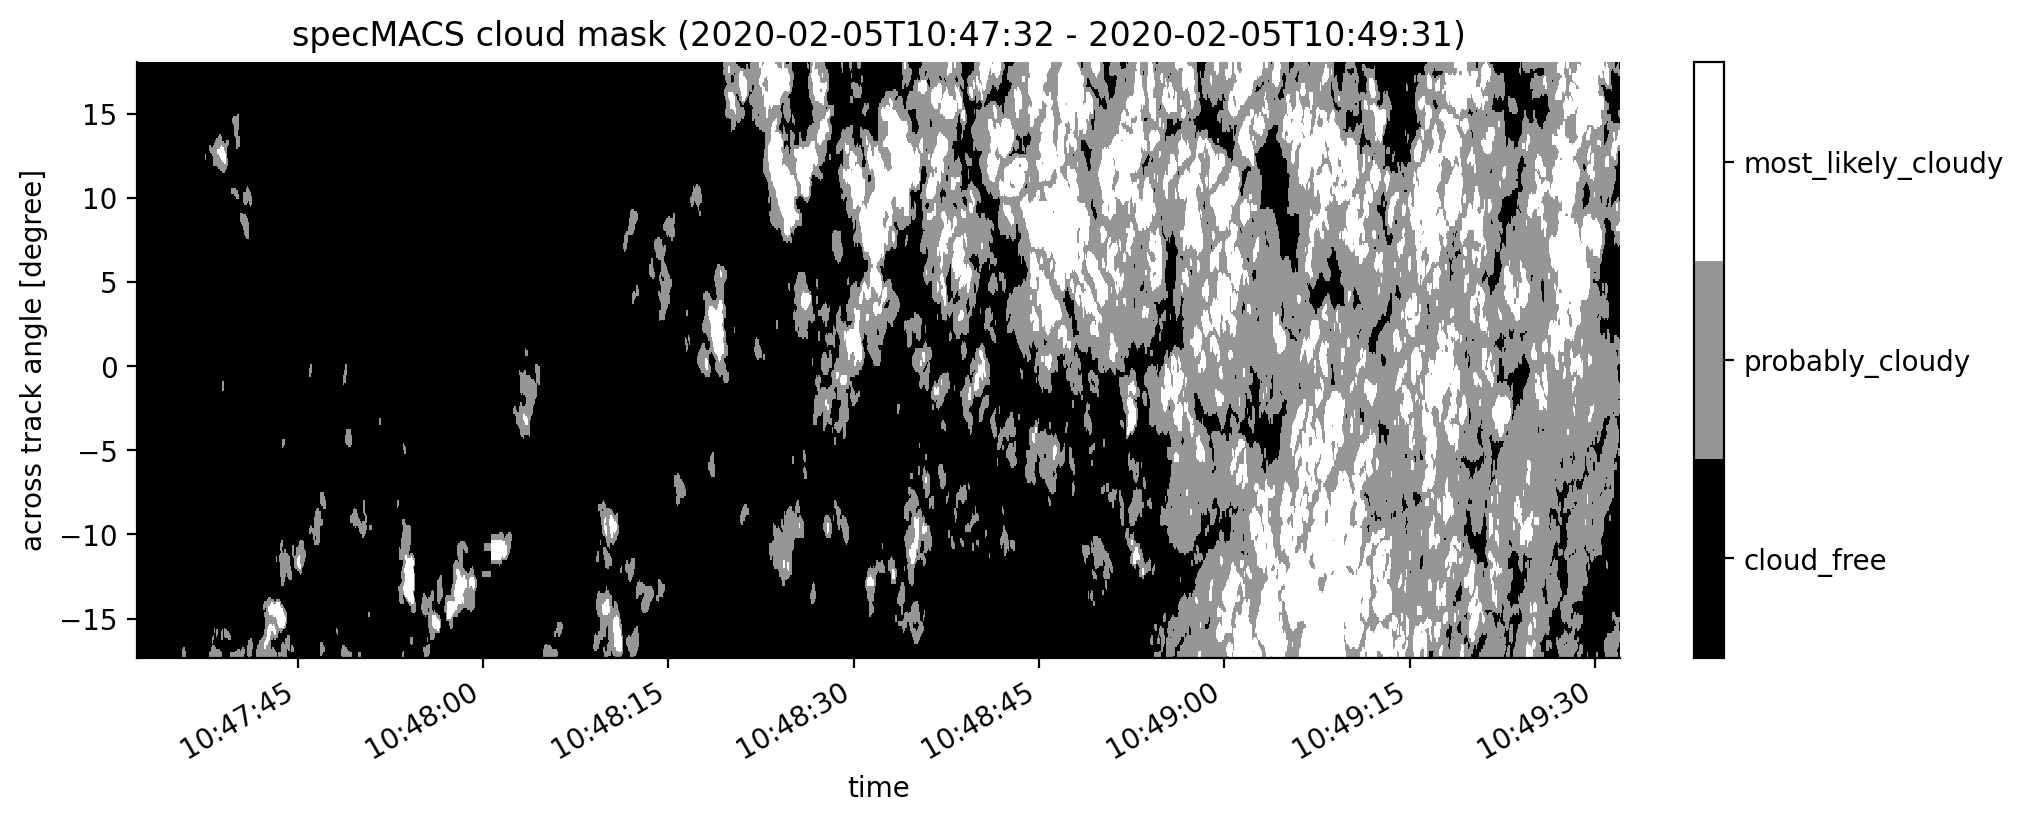

In [10]:
fig, ax = plt.subplots()
cmplot = ds_selection.cloud_mask.T.plot(ax=ax,
                                        cmap=plt.get_cmap('Greys_r', lut=3),
                                        vmin=-0.5, vmax=2.5,
                                        add_colorbar=False)
flagbar(fig, cmplot, ds_selection.cloud_mask)
start_time_rounded, end_time_rounded = ds_selection.time.isel(time=[0, -1]).values.astype('datetime64[s]')
ax.set_title(f"specMACS cloud mask ({start_time_rounded} - {end_time_rounded})");

The dataset also contains the minimal and maximal cloud fractions which are calculated for each temporal measurement. The minimal cloud fraction is derived from the ratio between the number of pixels classified as "most likely cloudy" and the total number of pixels in one measurement (times with unknown measurements are excluded). The maximal cloud fraction additionally includes the number of pixels classified as "probably cloudy".

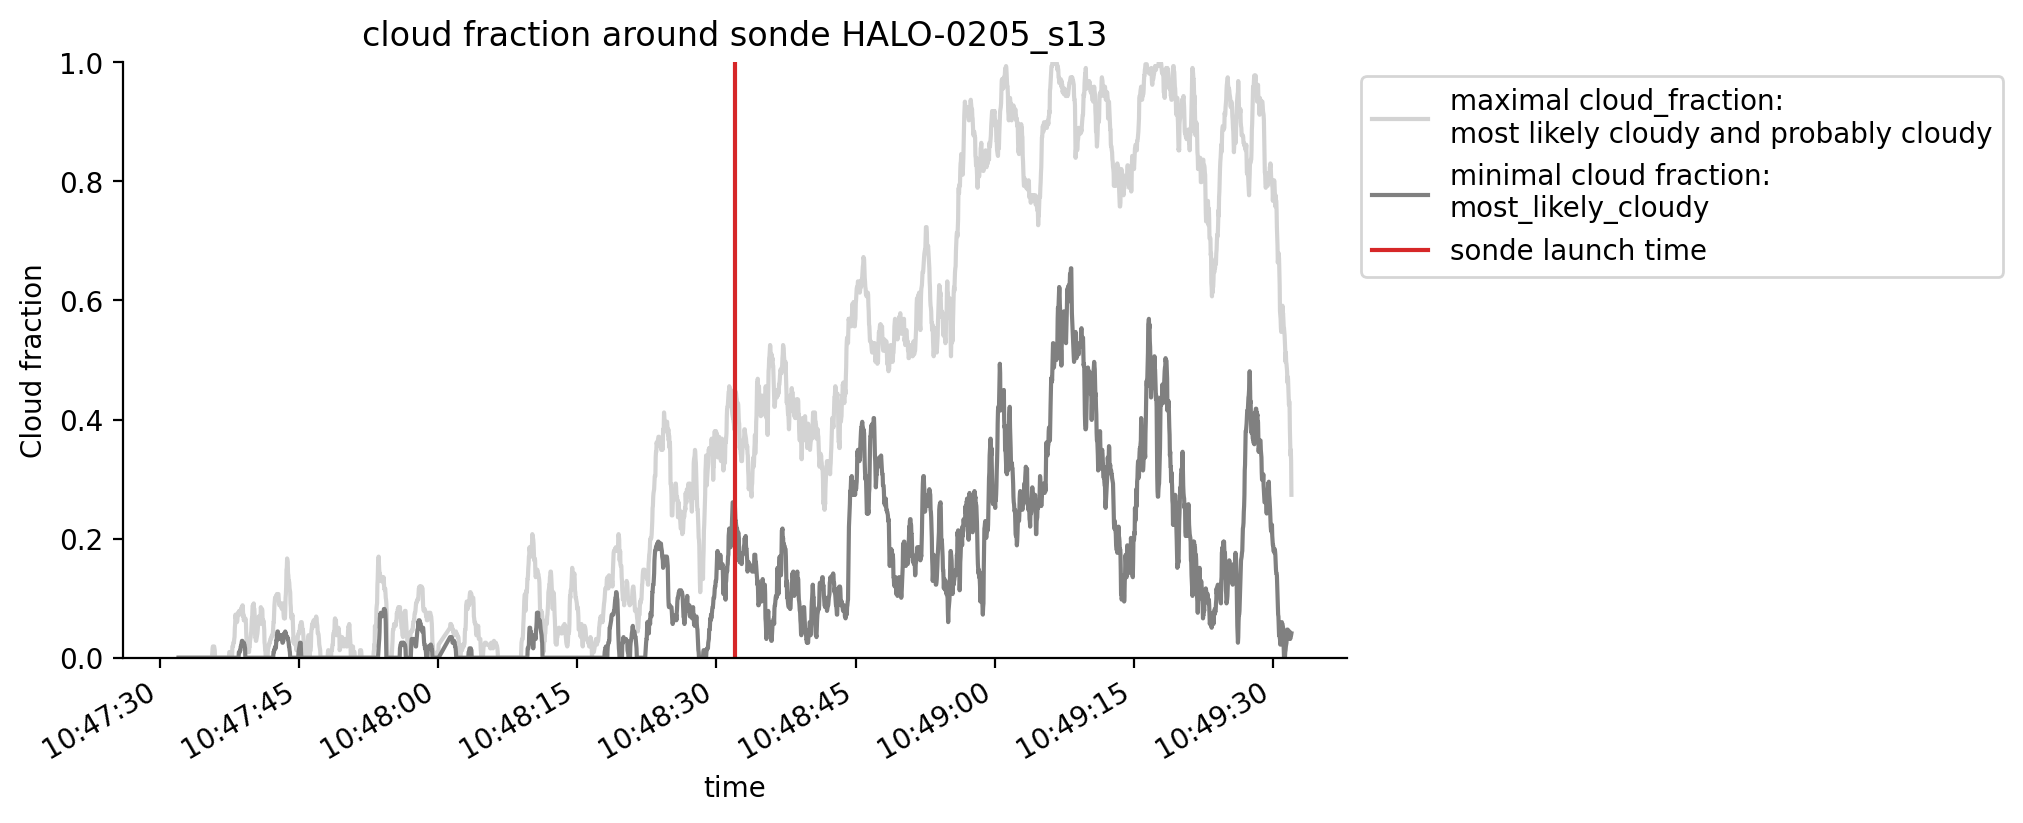

In [11]:
fig, ax = plt.subplots()
ds_selection.CF_max.plot(color="lightgrey",label="maximal cloud_fraction:\nmost likely cloudy and probably cloudy")
ds_selection.CF_min.plot(color="grey", label="minimal cloud fraction:\nmost_likely_cloudy")
ax.axvline(sonde_dt, color="C3", label="sonde launch time")
ax.set_ylim(0, 1)
ax.set_ylabel("Cloud fraction")
ax.set_title(f"cloud fraction around sonde {first_dropsonde}")
ax.legend(bbox_to_anchor=(1,1), loc="upper left");

## Camera view angles to latitude and longitude

The cloud mask is given on a `time` $\times$ `angle` grid where `angle`s are the internal camera angles. Sometimes it could be helpful to project the data onto a map. This means that we would like to know the corresponding **latitude** and **longitude** coordinates of each pixel of the cloud mask.

```{figure} specmacs_lat_lon.jpg
:alt: schematic drawing
:width: 50%
:align: center
```
The computation involves quite a few steps, so let's take a second to lay out a strategy.
We know already the position of the aircraft and the individual viewing directions of each sensor pixel at each point in time.
If we would start from the position of the aircraft and continue along each line of sight, until we hit something which we see in our dataset, we should end up at the location we are interested in.
Due to the curvature of the earth, we'll have to do a few coordinate transformations in the process, but no worries, we'll walk you through.

### What we know

We start out with five variables:
* position of the airplane: latitude, longitude and height above WGS84 (`ds.lat, ds.lon, ds.alt`)
* viewing directions of the camera pixels: viewing zenith angle and viewing azimuth angle (`ds.vza, ds.vaa`)

Let's have a look a these variables

In [12]:
def attr_table(variables):
    """
    Create a table of variable attributes from a list of variables (xr.DataArrays).

    The result is a HTML object, displayable by jupyter notebooks.
    """
    from IPython.display import HTML
    key_prio = {"standard_name": -2, "units": -1, "description": 1}
    keys = list(sorted(
        set(k for v in variables for k in v.attrs if not k.startswith("_")),
        key=lambda x: key_prio.get(x, 0)
    ))
    table = "<table><thead><tr>"
    table += "<th style=\"text-align: left\">name</th>" + "".join(f"<th style=\"text-align: left\">{k}</th>" for k in keys)
    table += "</tr></thead>"
    table += "<tbody>"
    for var in variables:
        table += f"<tr><td style=\"text-align: left\">{var.name}</td>"
        table += "".join(f"<td style=\"text-align: left\">{var.attrs.get(k, '-')}</td>" for k in keys) + "</tr>"
    table += "</tbody></table>"
    return HTML(table)

In [13]:
attr_table([ds_selection[key] for key in ["lat", "lon", "alt", "vza", "vaa"]])

name,standard_name,units,long_name,description
lat,latitude,degrees_north,latitude,Platform latitude coordinate
lon,longitude,degrees_east,longitude,Platform longitude coordinate
alt,-,m,altitude,Platform height above WGS 84 ellipsoid
vza,-,degree,viewing sensor zenith angle,angle between the line of sight to each pixel of the sensor and the local vertical at HALO position with respect to the WGS 84 ellipsoid
vaa,-,degree,viewing sensor azimuth angle,horizontal angle between the line of sight to each pixel of the sensor and due north (measured clockwise from north)


* The position of the HALO is saved in ellipsoidal coordinates. It is defined by the latitude (`lat`), longitude (`lon`) and height (`alt`) coordinates with respect to the WGS-84 ellipsoid.
* The viewing zenith (`vza`) and azimuth (`vaa`) angles are given with respect to the local horizon (`lh`) coordinate system at the position of the HALO. This system has its center at the `lat`/`lon`/`alt` position of the HALO and the x/y/z axis point into North, East and down directions.

As the frame of reference rotates with the motion of HALO, a convenient way to work with such kind of data is to transform it into the Earth-Centered, Earth-Fixed (ECEF) coordinate system. The origin of this coordinate system is the center of the Earth. The z-axis passes through true north, the x-axis through the Equator and the prime meridian at 0° longitude. The y-axis is orthogonal to x and z. This cartesian system makes computations of distances and angles very easy.

```{note}
The use of "altitude" and "height" can be confusing and is sometimes handled inconsistently. Usually, "altitude" describes the vertical distance above the geoid and "height" describes the vertical distance above the surface.

In this notebook, we only use the vertical distance above the WGS84 reference ellipsoid. Neither "altitude" nor "height" as defined above matches this distance exactly, but both are commonly used. We try to use the term "height" as it seems to be more commonly used in coordinate computations and fall back to the term `alt` when talking about the variable in HALO datasets. Keep in mind that we actually mean vertical distance above WGS84 in both cases.
```

### Transformation to ECEF

In a first step we want to transform the position of the HALO into the ECEF coordinate system. We use the method [from ESA navipedia](https://gssc.esa.int/navipedia/index.php/Ellipsoidal_and_Cartesian_Coordinates_Conversion):

In [14]:
def ellipsoidal_to_ecef(lat, lon, height):
    '''Transform ellipsoidal coordinates into the ECEF coordinate system according to:
    https://gssc.esa.int/navipedia/index.php/Ellipsoidal_and_Cartesian_Coordinates_Conversion

    Parameters:
    lat: latitude of ellipsoid [rad]
    lon: longitude of ellipsoid [rad]
    height: height above ellipsoid [m]
    
    Returns:
    coordinates in ECEF coordinate system.
    '''
    
    WGS_84_dict = {"axes": (6378137.0, 6356752.314245)} #m semi-minor and semi-major axis of WGS-84 geoid
    a, b = WGS_84_dict["axes"] #values come from: https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84
    
    e_squared = e2(a, b)
    N = calc_N(a, e_squared, lat)

    x = (N + height) * np.cos(lat) * np.cos(lon)
    y = (N + height) * np.cos(lat) * np.sin(lon)
    z = ((1 - e_squared)*N + height) * np.sin(lat)
    return np.stack([x,y,z], axis=-1)

def calc_N(a, e_squared, lat):
    '''Calculate the radius of curvature (N) in the prime vertical.
    
    Parameters:
    e_squared: eccentricity
    lat: latitude [rad]
    
    Returns:
    Radius of curvature in prime vertical.
    
    '''
    return a/np.sqrt(1 - e_squared*(np.sin(lat))**2)

def e2(a, b):
    '''This function calculates the squared eccentricity.
    
    Parameters:
    a: semi-major axis
    b: the semi-minor axis b 
    f: flattening factor f=1−ba
    
    Returns:
    Squared eccentricity.
    '''
    f = 1 - (b/a)
    e_squared = 2*f - f**2
    return e_squared

def ellipsoidal_to_ecef_ds(ds: xr.Dataset) -> xr.DataArray:
    '''
    This function applies the conversion from above directly to an xarray dataset.
    '''
    return xr.apply_ufunc(ellipsoidal_to_ecef, np.deg2rad(ds.lat), np.deg2rad(ds.lon), ds.alt,
                          output_core_dims=[("xyz_ecef",)])

With these functions it is easy to transform the `lat`/`lon`/`alt` position of the HALO into the ECEF-coordinate system.

In [15]:
HALO_ecef = ellipsoidal_to_ecef_ds(ds_selection)

### Computing viewing lines

As a next step we want to set up the vector of the viewing direction. We will need the rotation matrices `Rx`, `Ry` and `Rz` for this.
Using these fundamental rotation matrices, we can compute vectors along the instruments viewing direction in the local horizon (NED) coordinate system.

In [16]:
def R(alpha, axis, dim_a="a", dim_b="b"):
    dims = dict(zip(alpha.dims, alpha.shape))
    s = np.sin(alpha)
    c = np.cos(alpha)
    z = xr.DataArray(0, dims=()).expand_dims(dim=dims)
    o = xr.DataArray(1, dims=()).expand_dims(dim=dims)

    return xr.concat([
        xr.concat([o,  z, z], dim=dim_b),
        xr.concat([z,  c, s], dim=dim_b),
        xr.concat([z, -s, c], dim=dim_b),
    ], dim=dim_a) \
    .roll(shifts={dim_a: axis, dim_b: axis}, roll_coords=False)

def Rx(alpha, dim_a="a", dim_b="b"):
    return R(alpha, 0, dim_a, dim_b)

def Ry(alpha, dim_a="a", dim_b="b"):
    return R(alpha, 1, dim_a, dim_b)

def Rz(alpha, dim_a="a", dim_b="b"):
    return R(alpha, 2, dim_a, dim_b)


def vector_norm(x, dim, ord=None):
    return xr.apply_ufunc(
        np.linalg.norm, x, input_core_dims=[[dim]], kwargs={"ord": ord, "axis": -1}
    )

def normalize(x, dim, ord=None):
    return x / vector_norm(x, dim, ord)

def vector_lh(ds):
    '''Calculate the viewing direction relative to the local horizon (NED) coordinate system.
    The viewing direction is defined by the viewing zenith and azimuth angles which 
    are part of the dataset. If one thinks of a single pixel having its own coordinate system
    with +z being the central viewing direction of this pixel, the computation of the
    viewing direction can be carried out using two rotations:
    1. Rotation around the y-axis with the viewing zenith angle (pixel -> intermediate)
    2. Rotation around the z-axis with the viewinzg azimuth angle (intermediate -> NED)
    '''
    down = xr.DataArray(np.array([0,0,1]), dims=("pixel",))
    rot_vza = Ry(np.deg2rad(-ds["vza"]), "intermediate", "pixel")
    rot_vaa = Rz(np.deg2rad(-ds["vaa"]), "NED", "intermediate")
    # to simplify things later on, we attach coordinate labels to this system
    rot_vaa.coords["NED"] = xr.DataArray(["N", "E", "D"], dims=("NED",))

    return normalize(
        xr.dot(rot_vaa, rot_vza, down, dims=("pixel", "intermediate")),
        "NED"
    )

In [17]:
view_lh = vector_lh(ds_selection)

We need an approximation of the cloud top height and will use 1000 m as a first guess. If you have better cloud height data just put in your data. You can also use different values along `time` and `angle` dimensions, xarray will take care of this.

In [18]:
height_guess = 1000. #m
cth = xr.DataArray(height_guess, dims=())

Now let's calculate the length of the vector connecting HALO and the cloud. We need the height of the HALO, the cloudheight and the viewing direction for this. `view_lh` provides the viewing direction while the distance between HALO and cloud normalized by the down-component of the viewing direction provides the distance along the view path.

In [19]:
viewpath_lh = view_lh * (ds_selection.alt - cth) / view_lh.sel(NED="D")

Now we would like to transform this viewpath also into the ECEF coordinate system. We will stick to the method described [in navipedia](https://gssc.esa.int/navipedia/index.php/Transformations_between_ECEF_and_ENU_coordinates):

In [20]:
def lh_to_ecef(ned_vector, lat, lon):
    '''
    Transform vector of coordinates/directions with respect to the local horizon coordinate system
    into the ECEF system. While the reference uses ENU coordinates, we use NED in this example.

    see: https://gssc.esa.int/navipedia/index.php/Transformations_between_ECEF_and_ENU_coordinates
    
    Parameters:
    ned_vector: coordinates as expressed in local horizon coordinates/NED coordinates
    lat: latitude of HALO position [degree]
    lon: longitude of HALO position [degree]
    
    Returns:
    Vector expressed in ECEF coordinates.
    '''
    rot_matrix_inv = xr.dot(
        Ry(xr.DataArray(np.deg2rad(90), dims=()), "xyz_ecef", "m"),
        Rx(-np.deg2rad(lon), "m", "n"),
        Ry(np.deg2rad(lat), "n", "NED"),
        dims=("m", "n")
    )
    return xr.dot(rot_matrix_inv, ned_vector, dims="NED")

In [21]:
viewpath_ecef = lh_to_ecef(viewpath_lh,
                           ds_selection["lat"],
                           ds_selection["lon"])

### Cloud locations in 3D space

If we add the viewpath to the position of the HALO the resulting point gives us the ECEF coordinates of the point on the cloud.

In [22]:
cloudpoint_ecef = HALO_ecef + viewpath_ecef
x_cloud, y_cloud, z_cloud = cloudpoint_ecef.transpose("xyz_ecef", "time", "angle")

### Back to ellipsoidal coordinates

The last step is to transform these coordinates into ellipsoidal coordinates. Again we stick to the description [at navipedia](https://gssc.esa.int/navipedia/index.php/Ellipsoidal_and_Cartesian_Coordinates_Conversion):

In [23]:
def ecef_to_ellipsoidal(x, y, z, iterations=10):
    '''Transformation from ECEF coordinates to ellipsoidal coordinates according to:
    https://gssc.esa.int/navipedia/index.php/Ellipsoidal_and_Cartesian_Coordinates_Conversion

    Parameters:
    x, y, z: cartesian coordinates (ECEF)
    iterations: increase this value if the change between two successive values 
                of latitude is larger than the precision required.
    Returns:
    Vector expressed in ellipsoidal coordinates.
    '''
    WGS_84_dict = {"axes": (6378137.0, 6356752.314245)} #m
    a, b = WGS_84_dict["axes"] #semi-major and semi-minor axis a and b of the WGS-84 ellipsoid
        
    lon = np.arctan2(y,x) #radians    
    e_squared = e2(a, b)    
    p = np.sqrt(x**2 + y**2)     
    lat = np.arctan2(z, (1 - e_squared)*p)    
    
    for i in range(iterations):
        N = calc_N(a, e_squared, lat)
        height = p / np.cos(lat) - N
        lat = np.arctan2(z, (1-e_squared * (N/(N+height)))*p)

    lat = np.rad2deg(lat)
    lat.attrs["units"] = "degree_north"
    lon = np.rad2deg(lon)
    lon.attrs["units"] = "degree_east"
    return {"lat": lat,
            "lon": lon,
            "height": height}

In [24]:
ds_selection = ds_selection.assign_coords(
    {"cloud" + k: v for k, v in ecef_to_ellipsoidal(x_cloud, y_cloud, z_cloud, iterations=10).items()}
)
ds_selection

<xarray.Dataset>
Dimensions:      (angle: 318, time: 3564)
Coordinates:
  * time         (time) datetime64[ns] 2020-02-05T10:47:32.015175168 ... 2020...
  * angle        (angle) float64 18.0 17.9 17.8 17.69 ... -17.07 -17.17 -17.27
    lat          (time) float64 14.3 14.3 14.3 14.3 ... 14.26 14.26 14.26 14.26
    lon          (time) float64 -57.67 -57.67 -57.67 ... -57.42 -57.42 -57.42
    alt          (time) float32 1.026e+04 1.026e+04 ... 1.026e+04 1.026e+04
    cloudlat     (time, angle) float64 14.28 14.28 14.28 ... 14.28 14.28 14.28
    cloudlon     (time, angle) float64 -57.66 -57.66 -57.66 ... -57.4 -57.4
    cloudheight  (time, angle) float64 1.001e+03 1.001e+03 ... 1.001e+03
Data variables:
    CF_min       (time) float64 0.0 0.0 0.0 0.0 ... 0.03774 0.03774 0.04088
    CF_max       (time) float64 0.0 0.0 0.0 0.0 ... 0.3396 0.3491 0.3302 0.2736
    cloud_mask   (time, angle) float32 ...
    vza          (time, angle) float32 16.09 15.98 15.89 ... 20.47 20.57 20.67
    vaa          (time, angle) float32 159.0 158.9 158.8 ... 28.77 28.69 28.61
Attributes: (12/16)
    title:                           cloud mask derived from specMACS SWIR ca...
    version:                         2.1
    variable:                        cloud_mask
    comment:                         The additional information about the vie...
    contact:                         veronika.poertge@physik.uni-muenchen.de
    platform:                        HALO
    ...                              ...
    author:                          Veronika Pörtge, Felix Gödde, Tobias Köl...
    history:                         The original version of the cloud mask w...
    created_on:                      2021-03-12
    Conventions:                     CF-1.8
    references:                      more information about the product can b...
    DODS_EXTRA.Unlimited_Dimension:  time

## Display on a map
`ds.cloudlon` and `ds.cloudlat` are the projected longitude and latitude coordinates of the cloud. Now it is possible to plot the cloudmask on a map!

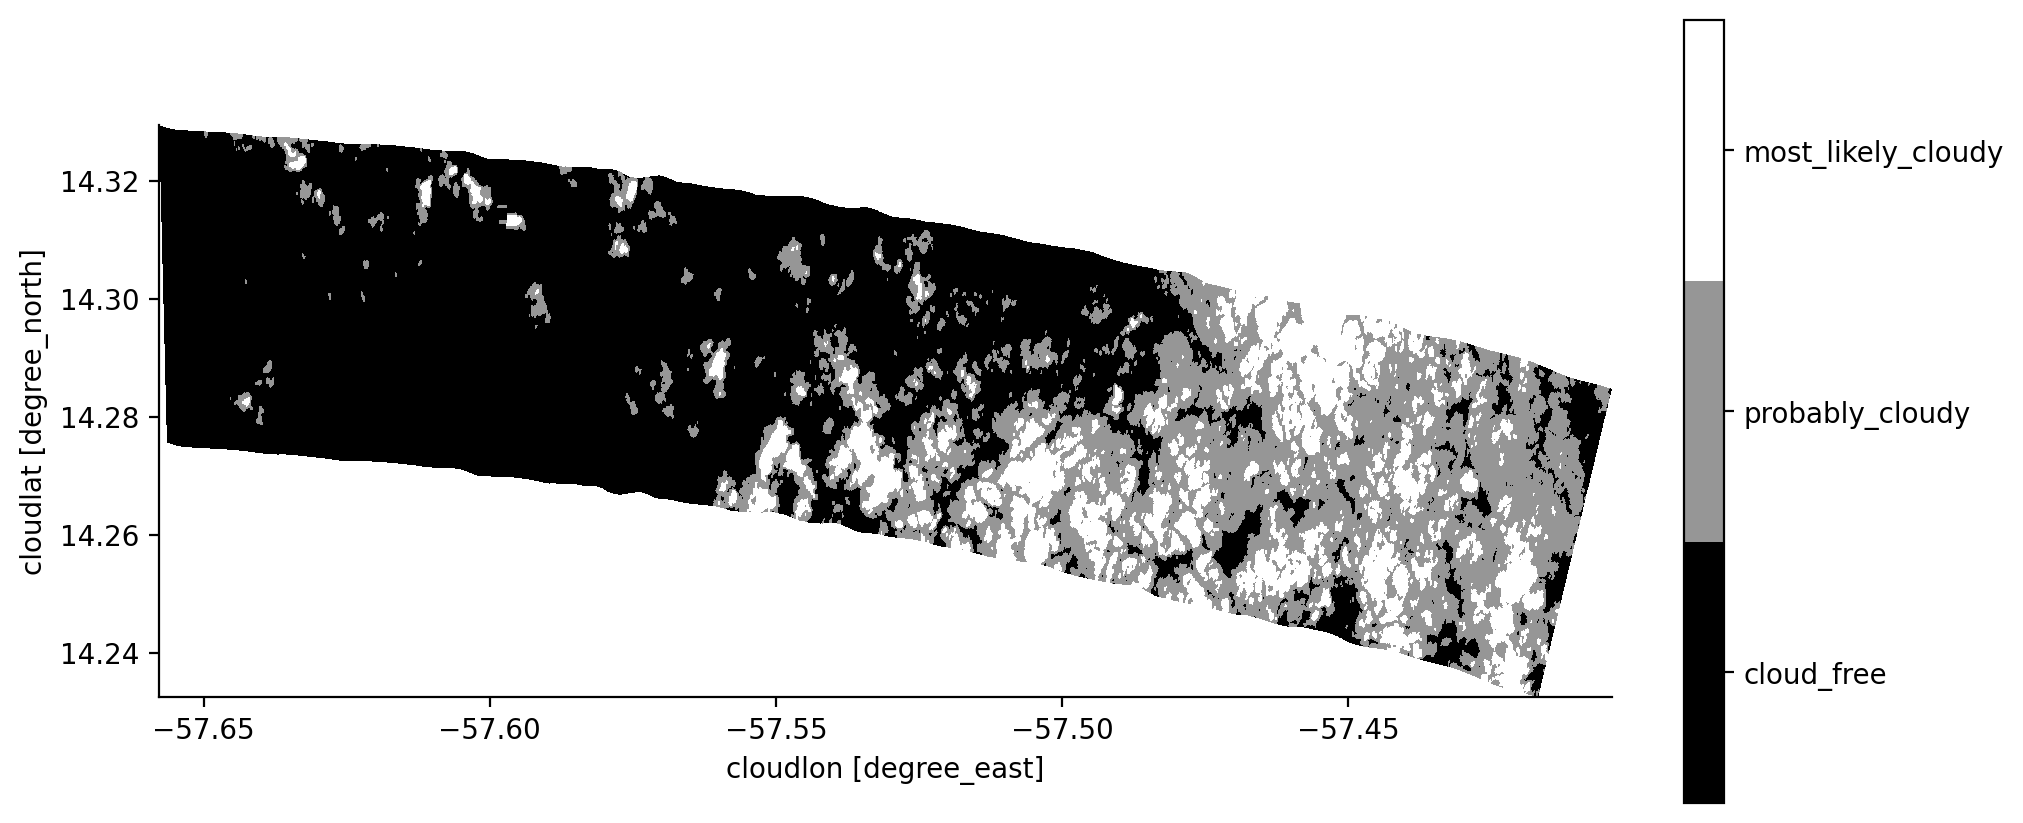

In [25]:
fig, ax = plt.subplots()
cmplot = ds_selection.cloud_mask.plot(ax=ax,
                                      x='cloudlon', y='cloudlat',
                                      cmap=plt.get_cmap('Greys_r', lut=3),
                                      vmin=-0.5, vmax=2.5,
                                      add_colorbar=False)
# approximate aspect ratio of latitude and longitude length scales
ax.set_aspect(1./np.cos(np.deg2rad(float(ds_selection.cloudlat.mean()))))
flagbar(fig, cmplot, ds_selection.cloud_mask);

In this two-minute long sequence we can see the curvature of the HALO circle. By the way: you could also calculate the swath width of the measurements projected onto the cloud height that you specified. 

## Swath width

The [haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) is such an approximation. It calculates the great-circle distance between two points on a sphere. We just need the respective latitudes and longitudes of the points. We will use the coordinates of the two edge pixels of the first measurement.

In [26]:
def haversine_distance(lat1, lat2, lon1, lon2, R = 6371):
    '''This formula calculates the great-circle distance between two points on a sphere with radius R in km.
    (https://en.wikipedia.org/wiki/Haversine_formula)
    
    Parameters:
    lat1: latitude of first point in radians
    lat2: latitude of second point in radians
    lon1: longitude of first point in radians
    lon2: longitude of second point in radians
    R   : Radius of sphere in km
    
    Returns: 
    Great-circle distance in km.
    '''
    dlon = lon2-lon1
    dlat = lat2-lat1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    distance_haversine_formula = R * 2 * np.arcsin(np.sqrt(a))
    return distance_haversine_formula


lat1 = np.deg2rad(ds_selection.isel(time=0).isel(angle=0).cloudlat)
lat2 = np.deg2rad(ds_selection.isel(time=0).isel(angle=-1).cloudlat)

lon1 = np.deg2rad(ds_selection.isel(time=0).isel(angle=0).cloudlon)
lon2 = np.deg2rad(ds_selection.isel(time=0).isel(angle=-1).cloudlon)

In [27]:
distance_haversine_formula = haversine_distance(lat1, lat2, lon1, lon2, R = 6371)
print('The across track swath width of the measurements is about {} km'.format(np.round(distance_haversine_formula.values,2)))

The across track swath width of the measurements is about 5.96 km
